# 데이터 준비

In [13]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import random

# 시각화 

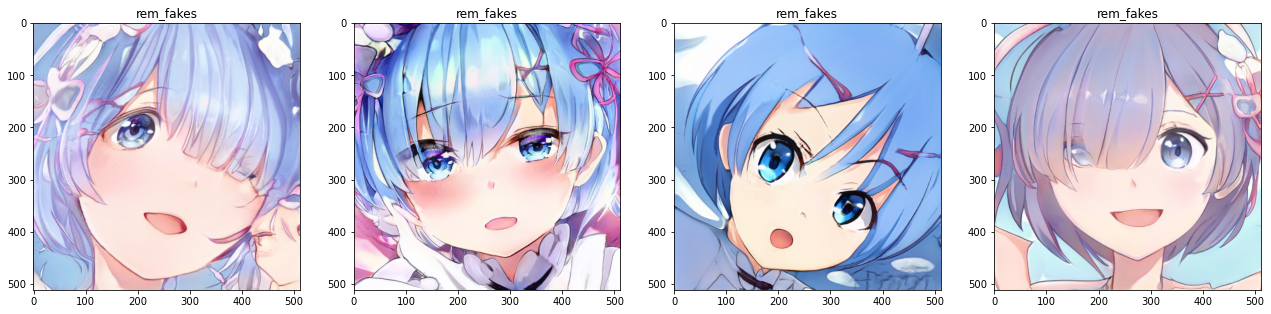

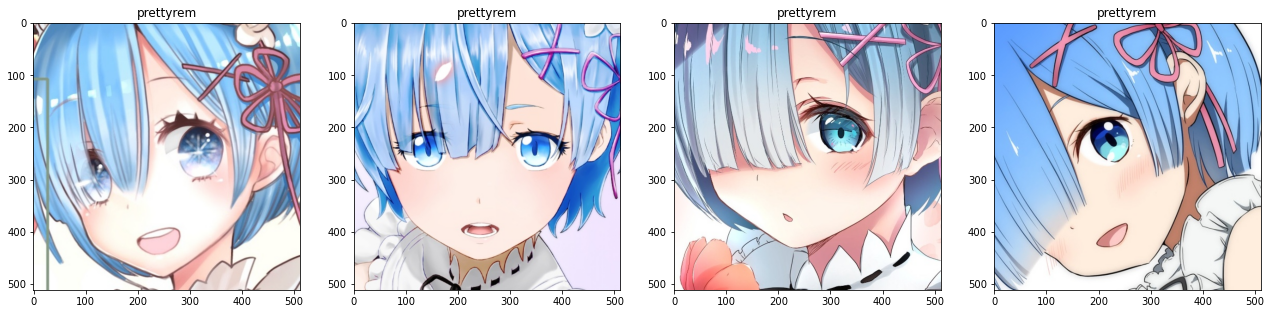

In [22]:
rem_fakes =glob.glob('data/rem/rem_fakes/*.png')

figure, axes = plt.subplots(figsize=(22, 10), nrows=1, ncols=4)


for i in range(4):
    rand_i = np.random.randint(0, len(rem_fakes))
    rem_image = cv2.cvtColor(cv2.imread(rem_fakes[rand_i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(rem_image)
    axes[i].set_title('rem_fakes')

prettyrem =glob.glob('data/rem/rem_preprocessed_512/*.jpg')

figure, axes = plt.subplots(figsize=(22, 10), nrows=1, ncols=4)


for i in range(4):
    rand_i = np.random.randint(0, len(prettyrem))
    rem_image = cv2.cvtColor(cv2.imread(prettyrem[rand_i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(rem_image)
    axes[i].set_title('prettyrem')

# 테스트 데이터 분리

In [4]:
train_dataset = keras.utils.image_dataset_from_directory(
    "data/rem", 
    image_size=(224,224),
    label_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1,
    subset="training",
    validation_split=0.2
)

validation_dataset = keras.utils.image_dataset_from_directory(
    "data/rem", 
    image_size=(224,224),
    label_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1,
    subset="validation",
    validation_split=0.2, 
)

train_dataset = train_dataset.cache().prefetch(1)
validation_dataset = validation_dataset.cache().prefetch(1)

Found 1725 files belonging to 2 classes.
Using 1380 files for training.
Found 1725 files belonging to 2 classes.
Using 345 files for validation.


# 모델 생성

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

base = MobileNetV2(weights='imagenet', include_top=False)
base.trainable = False

model = keras.Sequential([
    layers.Rescaling(scale=1.0 / 255.0, offset=-1),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

# 모델 훈련

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
	EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
	ReduceLROnPlateau(monitor='val_loss', min_lr=1e-7, patience=2, mode='min', verbose=1, factor=0.1),
	ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)
]

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

history = model.fit(train_dataset, epochs=50,
					callbacks=callbacks, validation_data=validation_dataset)

Epoch 1/50
44/44 [==============================] - 95s 2s/step - loss: 0.7461 - accuracy: 0.5413 - val_loss: 0.6727 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 80s 2s/step - loss: 0.6486 - accuracy: 0.6435 - val_loss: 0.6098 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 83s 2s/step - loss: 0.5744 - accuracy: 0.7029 - val_loss: 0.5805 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 76s 2s/step - loss: 0.5442 - accuracy: 0.7304 - val_loss: 0.5595 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 76s 2s/step - loss: 0.5315 - accuracy: 0.7312 - val_loss: 0.5438 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 92s 2s/step - loss: 0.5130 - accuracy: 0.7616 - val_loss: 0.5350 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 84s 2s/step - loss: 0.4952 - a

# 모델 평가

In [8]:
model.evaluate(validation_dataset)

11/11 [==============================] - 12s 1s/step - loss: 0.4437 - accuracy: 0.7913


[0.4437442123889923, 0.791304349899292]

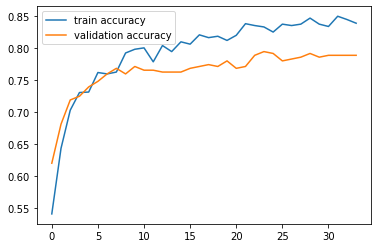

In [9]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

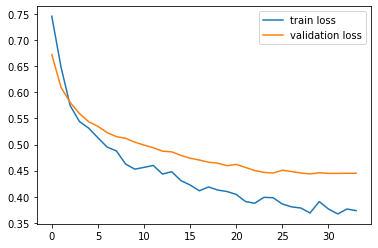

In [10]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()